<a href="https://colab.research.google.com/github/MehrdadDastouri/time_series_prediction_tcn/blob/main/time_series_prediction_tcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [1/50], Loss: 0.9590
Epoch [2/50], Loss: 0.6984
Epoch [3/50], Loss: 0.4151
Epoch [4/50], Loss: 0.3957
Epoch [5/50], Loss: 0.3976
Epoch [6/50], Loss: 0.3880
Epoch [7/50], Loss: 0.3872
Epoch [8/50], Loss: 0.3812
Epoch [9/50], Loss: 0.3790
Epoch [10/50], Loss: 0.3689
Epoch [11/50], Loss: 0.3734
Epoch [12/50], Loss: 0.3717
Epoch [13/50], Loss: 0.3677
Epoch [14/50], Loss: 0.3794
Epoch [15/50], Loss: 0.3702
Epoch [16/50], Loss: 0.3667
Epoch [17/50], Loss: 0.3738
Epoch [18/50], Loss: 0.3664
Epoch [19/50], Loss: 0.3662
Epoch [20/50], Loss: 0.3580
Epoch [21/50], Loss: 0.3662
Epoch [22/50], Loss: 0.3673
Epoch [23/50], Loss: 0.3682
Epoch [24/50], Loss: 0.3645
Epoch [25/50], Loss: 0.3500
Epoch [26/50], Loss: 0.3573
Epoch [27/50], Loss: 0.3613
Epoch [28/50], Loss: 0.3524
Epoch [29/50], Loss: 0.3555
Epoch [30/50], Loss: 0.3577
Epoch [31/50], Loss: 0.3557
Epoch [32/50], Loss: 0.3618
Epoch [33/50], Loss: 0.3636
Epoch [34/50], Loss: 0.3568
Epoch [35/50], Loss: 0.3464
Epoch [36/50], Loss: 0.3493
E

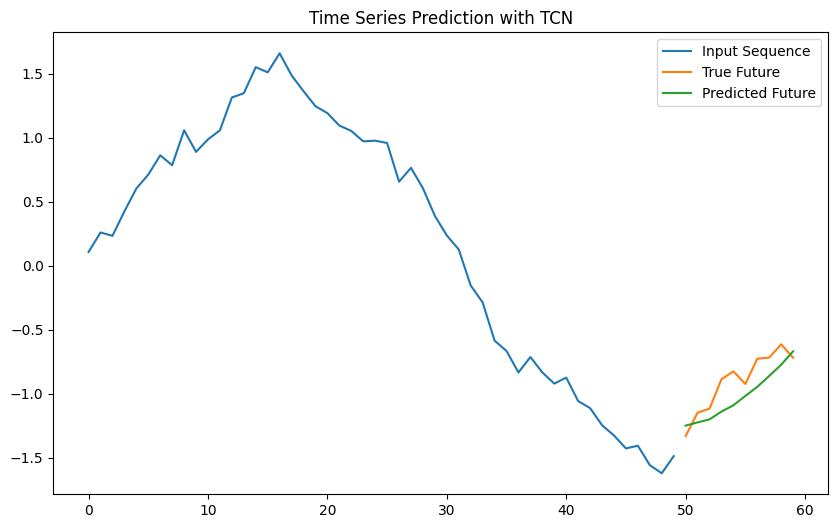

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate synthetic time series data (sine wave)
def generate_time_series(length=1000):
    x = np.linspace(0, 100, length)
    y = np.sin(x) + 0.1 * np.sin(5 * x) + 0.05 * np.random.normal(size=length)
    return y

data = generate_time_series()

# Normalize the data
data = (data - np.mean(data)) / np.std(data)

# Create a custom dataset class for time series
class TimeSeriesDataset(Dataset):
    def __init__(self, series, input_length, output_length):
        self.series = series
        self.input_length = input_length
        self.output_length = output_length

    def __len__(self):
        return len(self.series) - self.input_length - self.output_length

    def __getitem__(self, idx):
        x = self.series[idx : idx + self.input_length]
        y = self.series[idx + self.input_length : idx + self.input_length + self.output_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Hyperparameters
input_length = 50  # Number of input time steps
output_length = 10  # Number of output time steps
batch_size = 32
epochs = 50
learning_rate = 0.001

# Prepare dataset and dataloader
dataset = TimeSeriesDataset(data, input_length, output_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the Temporal Convolutional Network (TCN)
class TCN(nn.Module):
    def __init__(self, input_dim, output_dim, num_channels, kernel_size=2, dropout=0.2):
        super(TCN, self).__init__()
        layers = []
        for i in range(len(num_channels)):
            in_channels = input_dim if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers.append(nn.Conv1d(in_channels, out_channels, kernel_size, padding=(kernel_size - 1) * (2 ** i), dilation=2 ** i))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.network(x)
        x = x[:, :, -1]  # Keep the last time step
        x = self.fc(x)
        return x

# Initialize the TCN model
num_channels = [16, 32, 64]
model = TCN(input_dim=1, output_dim=output_length, num_channels=num_channels).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        # Forward pass
        outputs = model(x)
        loss = criterion(outputs, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(dataloader):.4f}")

# Test the model
model.eval()
test_input = dataset[0][0].unsqueeze(0).to(device)  # Use the first sample for testing
test_output = model(test_input).detach().cpu().numpy()
test_truth = dataset[0][1].numpy()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(input_length), test_input.squeeze().cpu().numpy(), label="Input Sequence")
plt.plot(range(input_length, input_length + output_length), test_truth, label="True Future")
plt.plot(range(input_length, input_length + output_length), test_output.squeeze(), label="Predicted Future")
plt.legend()
plt.title("Time Series Prediction with TCN")
plt.show()